# Solving Max-Cut problem using QAOA

### Combinatorial Optimization

Combinatorial optimization  means searching for an optimal solution in a finite or countably infinite set of potential solutions. Optimality is defined with respect to some criterion function, which is to be minimized or maximized, which is typically called the cost function.

There are various types of optimization problems. These include Minimization: cost, distance, length of a traversal, weight, processing time, material, energy consumption, number of objects. Maximization: profit, value, output, return, yield, utility, efficiency, capacity, number of objects. Any maximization problem can be cast in terms of a minimization problem and vice versa. Hence the general form a combinatorial optimization problem is given by


$$maximize\ C(x)$$
$$ subject\  to\  x \in S$$

where  $x \in S$
 , is a discrete variable and  $C:D \rightarrow R$
  is the cost function, that maps from some domain   $S$
  in to the real numbers  
$R$
 . The variable  
$x$
  can be subject to a set of constraints and lies within the set  
$S \subset D$
  of feasible points.

In binary combinatorial optimization problems, the cost function  
$C$
  can typically be expressed as a sum of terms that only involve a subset  
$Q
\subset
[
n
]$
  of the  
$n$
  bits in the string  
$x \in
\{
0
,
1
\}^
n$
  and is written in the canonical form:

  $$ C(x) = \sum_{(Q,\tilde{Q})} w_{(Q,\tilde{Q})} \prod_{i \in Q} x_i \prod_{j \in \tilde{Q}} (1 - x_j) $$
  where,

  $x_i \in \{0,1\}$ and $w_{(Q, \tilde{Q})} \in R$


  We want to find the n-bit string  
$x$
  for which  
$C
(
x
)$
  is the maximal

# Using Quantum Computing
## Diagnol Hamiltonians

This cost function can be mapped to a Hamiltonian that is diagonal in the computational basis. Given the cost-function  
$C$ this Hamiltonian is then written as

$$ H  = \sum_{x \in \{0,1 \}^n} C(x)|x⟩⟨x|$$

where $x \in \{0,1\}^n$ labels the computational basis states. 
 If the cost function only has at most weight  $k$ terms, i.e. when only  
$Q$ contribute that involve at most  
$Q ≤ k$ bits, then this diagonal Hamiltonian is also only a sum of weight  
$k$ Pauli  $Z$
  operators.

## Load the Qiskit and additional Packages 

In [2]:
import numpy as np
import networkx as nx  # tool to handle general Graphs 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

## Problem Statement

We define the cost function in terms of the butterfly graph of the superconducting chip. The graph has  
$n=5$ vertices  
$V=\{0,1,2,3,4\}$ and six edges  $E=\{(0,1),(0,2),(1,2),(3,2),(3,4),(4,2)\}$
 , which will all carry the same unit weight $w_{ij}=1$
 . We load an additional network package to encode the graph and plot connectivity below.

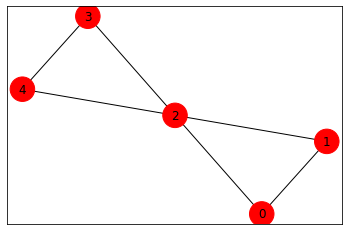

In [3]:
# Generating the butterfly graph with 5 nodes 
n = 5
V = np.arange(0,n,1)
E =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

## Trial State Parameters

We consider the case for  
$p=1$
 , i.e. only layer of gates.

 


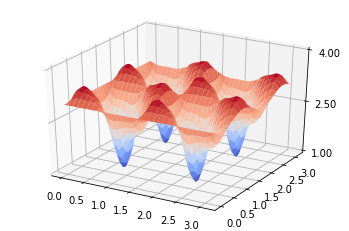


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [4]:
# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

In [5]:
# prepare the quantum and classical resisters
QAOA = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
QAOA.h(range(len(V)))
QAOA.barrier()

# apply the Ising type gates with angle gamma along the edges in E
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cp(-2*gamma, k, l)
    QAOA.p(gamma, k)
    QAOA.p(gamma, l)
    
# then apply the single qubit X rotations with angle beta to all qubits
QAOA.barrier()
QAOA.rx(2*beta, range(len(V)))

# Finally measure the result in the computational basis
QAOA.barrier()
QAOA.measure(range(len(V)),range(len(V)))

### draw the circuit for comparison
QAOA.draw()

┌───┐ ░           ┌────────┐          ┌────────┐                    »
q_0: ┤ H ├─░──■────────┤ P(1.9) ├─■────────┤ P(1.9) ├────────────────────»
     ├───┤ ░  │P(-3.8) ├────────┤ │        └────────┘          ┌────────┐»
q_1: ┤ H ├─░──■────────┤ P(1.9) ├─┼───────────────────■────────┤ P(1.9) ├»
     ├───┤ ░           └────────┘ │P(-3.8) ┌────────┐ │P(-3.8) ├────────┤»
q_2: ┤ H ├─░──────────────────────■────────┤ P(1.9) ├─■────────┤ P(1.9) ├»
     ├───┤ ░                               └────────┘          └────────┘»
q_3: ┤ H ├─░─────────────────────────────────────────────────────────────»
     ├───┤ ░                                                             »
q_4: ┤ H ├─░─────────────────────────────────────────────────────────────»
     └───┘ ░                                                             »
c: 5/════════════════════════════════════════════════════════════════════»
                                                                         »
«                                                                  ░ »
«q_0: ─────────────────────────────────────────────────────────────░─»
«                                                                  ░ »
«q_1: ─────────────────────────────────────────────────────────────░─»
«               ┌────────┐                              ┌────────┐ ░ »
«q_2: ─■────────┤ P(1.9) ├─────────────────────■────────┤ P(1.9) ├─░─»
«      │P(-3.8) ├────────┤          ┌────────┐ │        └────────┘ ░ »
«q_3: ─■────────┤ P(1.9) ├─■────────┤ P(1.9) ├─┼───────────────────░─»
«               └────────┘ │P(-3.8) ├────────┤ │P(-3.8) ┌────────┐ ░ »
«q_4: ─────────────────────■────────┤ P(1.9) ├─■────────┤ P(1.9) ├─░─»
«                                   └────────┘          └────────┘ ░ »
«c: 5/═══════════════════════════════════════════════════════════════»
«                                                                    »
«     ┌─────────┐ ░ ┌─┐            
«q_0: ┤ RX(0.4) ├─░─┤M├────────────
«     ├─────────┤ ░ └╥┘┌─┐         
«q_1: ┤ RX(0.4) ├─░──╫─┤M├─────────
«     ├─────────┤ ░  ║ └╥┘┌─┐      
«q_2: ┤ RX(0.4) ├─░──╫──╫─┤M├──────
«     ├─────────┤ ░  ║  ║ └╥┘┌─┐   
«q_3: ┤ RX(0.4) ├─░──╫──╫──╫─┤M├───
«     ├─────────┤ ░  ║  ║  ║ └╥┘┌─┐
«q_4: ┤ RX(0.4) ├─░──╫──╫──╫──╫─┤M├
«     └─────────┘ ░  ║  ║  ║  ║ └╥┘
«c: 5/═══════════════╩══╩══╩══╩══╩═
«                    0  1  2  3  4

In [6]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

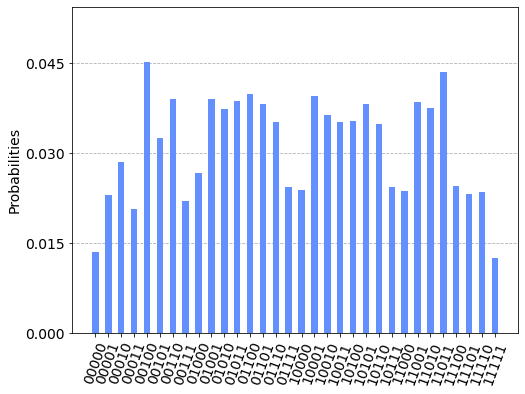

In [8]:
# run on local simulator
backend = Aer.get_backend("qasm_simulator")
shots = 10000

TQAOA = transpile(QAOA, backend)
qobj = assemble(TQAOA, shots=shots)
QAOA_results = backend.run(qobj).result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 3.32 while the true value is M1 = 3.43 

The approximate solution is x* = 01110 with C(x*) = 4 

The cost function is distributed as: 



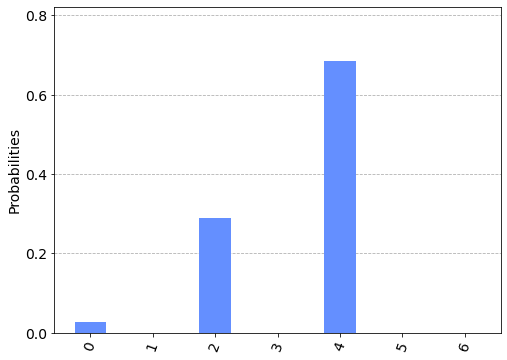

In [9]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

In [11]:
token ='c4cf845d24d07ef83f8c379aa5f6973baf8bb9b5ed45d32e80a4e380353bcaca4ca5d8e33f9941bcedd21f54bee41e0af55b9ca9448bc93f1403ec5093c123e5'

In [12]:

provider = IBMQ.save_account(token)

In [16]:
%matplotlib inline

from qiskit import *
from qiskit.visualization import *
from qiskit.tools.monitor import *

In [20]:
# Use the IBMQ essex device
#backend = Aer.get_backend('qasm_simulator')
provider = IBMQ.load_account()
backend_overview()



ibmqfactory.load_account:WARNING:2021-04-20 09:12:31,660: Credentials are already in use. The existing account in the session will be replaced.


ibmq_quito                   ibmq_belem                   ibmq_lima
----------                   ----------                   ---------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  5
Pending Jobs: 21             Pending Jobs: 35             Pending Jobs: 46
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      79.4           Avg. T1:      82.6           Avg. T1:      81.6
Avg. T2:      83.4           Avg. T2:      116.3          Avg. T2:      108.7



ibmq_santiago                ibmq_athens                  ibmq_armonk
-------------                -----------                  -----------
Num. Qubits:  5              Num. Qubits:  5              Num. Qubits:  1
Pending Jobs: 2120           Pending Jobs: 6233           Pending Jobs: 5
Least busy:   False          Least busy:   False          Least busy:   False
Operational:  True           Operati

In [21]:
backend = provider.get_backend('ibmq_quito')
shots = 2048

TQAOA = transpile(QAOA, backend)
qobj = assemble(TQAOA, shots=shots)
job_exp = backend.run(qobj)
job_monitor(job_exp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  


Job Status: job has successfully run


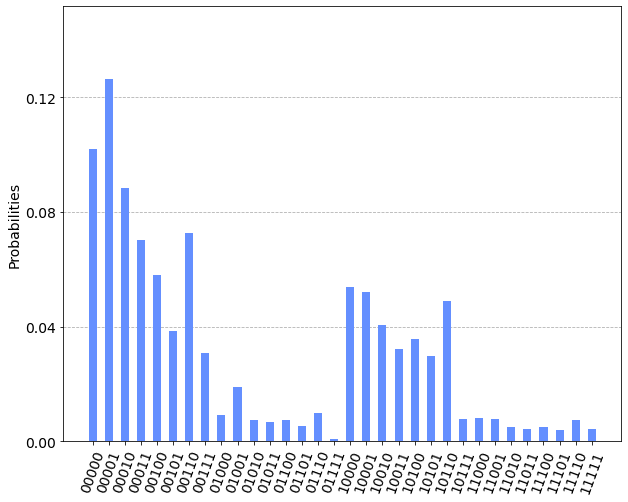

In [22]:
exp_results = job_exp.result()
plot_histogram(exp_results.get_counts(),figsize = (10,8),bar_labels = False)


 --- EXPERIMENTAL RESULTS ---

The sampled mean value is M1_sampled = 2.75 while the true value is M1 = 3.43 

The approximate solution is x* = 10001 with C(x*) = 4 

The cost function is distributed as: 



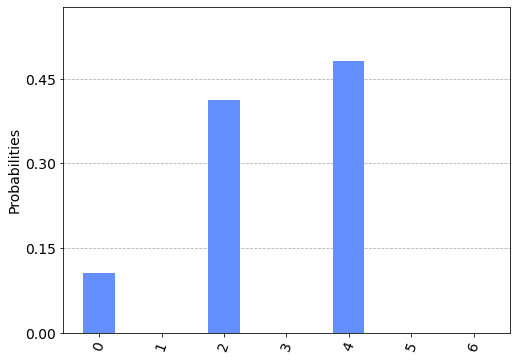

In [23]:
# Evaluate the data from the experiment
counts = exp_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- EXPERIMENTAL RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)